# Import

In [1]:
import sys

root_dir = '../../'
if root_dir not in sys.path:
    sys.path.append(root_dir)

import torch
from torch import nn, optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
import pandas as pd

pd.set_option('display.max_columns', 100)

from modules import losses, models, samplers, searches, regularizers, evaluators, trainers, datasets, distributions

# Dataset

In [2]:
dataset = datasets.ML20m()
n_user = dataset.n_user
n_item = dataset.n_item
train_set, test_set = dataset.get_train_and_test_set(neg_pair_weight=30)

# device setting
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_set = torch.LongTensor(train_set).to(device)
test_set = torch.FloatTensor(test_set).to(device)

# Evaluator

In [3]:
# k
ks = [5, 10, 50]

score_function_dict = {
    "Recall"      : evaluators.recall,
    "Unpopularity": evaluators.unpopularity,
    "Unpopularity2": evaluators.unpopularity2,
    "Unpopularity3": evaluators.unpopularity3,
    "F1-score"    : evaluators.f1_score,
    "F1-score2"    : evaluators.f1_score2,
    "F1-score3"    : evaluators.f1_score3
}
userwise = evaluators.UserwiseEvaluator(test_set, score_function_dict, ks)
# coverage = evaluators.CoverageEvaluator(test_set, ks)
# hubness = evaluators.HubnessEvaluator(test_set, ks)

# Sampler

In [4]:
sampler = samplers.BaseSampler(train_set, n_user, n_item, device=device, strict_negative=False)

# Model

In [5]:
# Hyperparameters
lr = 1e-3
n_dim = 30
n_batch = 256
n_epoch = 50
no_progressbar = True

model = models.CollaborativeMetricLearning(n_user, n_item, n_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = losses.SumTripletLoss(margin=1).to(device)
trainer = trainers.BaseTrainer(model, optimizer, criterion, sampler, no_progressbar)

# No Training Result

In [6]:
knn = searches.NearestNeighborhood(model)
trainer.valid(knn, userwise)
re_no_training = trainer.valid_scores.copy()
display(re_no_training)

,Recall@5,Unpopularity@5,Unpopularity2@5,Unpopularity3@5,F1-score@5,F1-score2@5,F1-score3@5,Recall@10,Unpopularity@10,Unpopularity2@10,Unpopularity3@10,F1-score@10,F1-score2@10,F1-score3@10,Recall@50,Unpopularity@50,Unpopularity2@50,Unpopularity3@50,F1-score@50,F1-score2@50,F1-score3@50
0,0.022503,0.959245,9.662793,0.022421,0.034344,0.043429,0.004989,0.045003,0.959401,9.66826,0.044872,0.069023,0.086986,0.018589,0.221508,0.957817,9.651761,0.221507,0.301959,0.420826,0.196074


# Training

In [7]:
# only traing no validation
trainer.fit(n_batch, n_epoch)

# Result

## Base CML

In [8]:
knn = searches.NearestNeighborhood(model)

# Recall
trainer.valid(knn, userwise)
re_base = trainer.valid_scores.copy()
display(re_base)

,Recall@5,Unpopularity@5,Unpopularity2@5,Unpopularity3@5,F1-score@5,F1-score2@5,F1-score3@5,Recall@10,Unpopularity@10,Unpopularity2@10,Unpopularity3@10,F1-score@10,F1-score2@10,F1-score3@10,Recall@50,Unpopularity@50,Unpopularity2@50,Unpopularity3@50,F1-score@50,F1-score2@50,F1-score3@50
0,0.235083,0.555053,1.83078,0.000848,0.228307,0.341663,0.000974,0.439426,0.526493,1.824474,0.003361,0.391897,0.638983,0.005554,0.844004,0.724991,4.121479,0.115431,0.767283,1.346512,0.166127


## CML+MP

In [9]:
n_sample = 600
bias_li = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
gamma = distributions.Gamma()

In [10]:
re_mpcml_li = []
for bias in bias_li:
    print(f'bias={bias}')
    mp = searches.NoDistinctionMutualProximity(model, gamma, n_sample, bias)
    trainer.valid(mp, userwise)
    re = trainer.valid_scores.copy()
    display(re)
    re_mpcml_li.append(re)

bias=0.0


,Recall@5,Unpopularity@5,Unpopularity2@5,Unpopularity3@5,F1-score@5,F1-score2@5,F1-score3@5,Recall@10,Unpopularity@10,Unpopularity2@10,Unpopularity3@10,F1-score@10,F1-score2@10,F1-score3@10,Recall@50,Unpopularity@50,Unpopularity2@50,Unpopularity3@50,F1-score@50,F1-score2@50,F1-score3@50
0,0.007491,0.975533,7.456894,0.020633,0.012864,0.014557,0.001012,0.019634,0.967148,7.60084,0.042365,0.032141,0.037662,0.004307,0.262759,0.909224,7.629929,0.210969,0.309757,0.469634,0.108429


bias=0.1


,Recall@5,Unpopularity@5,Unpopularity2@5,Unpopularity3@5,F1-score@5,F1-score2@5,F1-score3@5,Recall@10,Unpopularity@10,Unpopularity2@10,Unpopularity3@10,F1-score@10,F1-score2@10,F1-score3@10,Recall@50,Unpopularity@50,Unpopularity2@50,Unpopularity3@50,F1-score@50,F1-score2@50,F1-score3@50
0,0.013913,0.95224,6.65959,0.018123,0.023819,0.026779,0.001144,0.036886,0.937417,6.772588,0.03774,0.058431,0.069672,0.005275,0.390048,0.865052,6.768341,0.19225,0.427238,0.677057,0.129526


bias=0.2


,Recall@5,Unpopularity@5,Unpopularity2@5,Unpopularity3@5,F1-score@5,F1-score2@5,F1-score3@5,Recall@10,Unpopularity@10,Unpopularity2@10,Unpopularity3@10,F1-score@10,F1-score2@10,F1-score3@10,Recall@50,Unpopularity@50,Unpopularity2@50,Unpopularity3@50,F1-score@50,F1-score2@50,F1-score3@50
0,0.020279,0.933907,6.156235,0.016287,0.033636,0.038677,0.001282,0.056256,0.911668,6.185196,0.033877,0.084836,0.104343,0.006249,0.499151,0.831857,6.130501,0.176133,0.519204,0.849858,0.145506


bias=0.3


,Recall@5,Unpopularity@5,Unpopularity2@5,Unpopularity3@5,F1-score@5,F1-score2@5,F1-score3@5,Recall@10,Unpopularity@10,Unpopularity2@10,Unpopularity3@10,F1-score@10,F1-score2@10,F1-score3@10,Recall@50,Unpopularity@50,Unpopularity2@50,Unpopularity3@50,F1-score@50,F1-score2@50,F1-score3@50
0,0.027961,0.915697,5.729962,0.014628,0.044696,0.052588,0.001445,0.079329,0.885326,5.672664,0.030235,0.113774,0.144418,0.007186,0.588287,0.806365,5.635558,0.162387,0.589906,0.987623,0.156242


bias=0.4


,Recall@5,Unpopularity@5,Unpopularity2@5,Unpopularity3@5,F1-score@5,F1-score2@5,F1-score3@5,Recall@10,Unpopularity@10,Unpopularity2@10,Unpopularity3@10,F1-score@10,F1-score2@10,F1-score3@10,Recall@50,Unpopularity@50,Unpopularity2@50,Unpopularity3@50,F1-score@50,F1-score2@50,F1-score3@50
0,0.037085,0.896969,5.338244,0.013035,0.057469,0.068714,0.001557,0.106016,0.858307,5.199182,0.026673,0.144419,0.189161,0.007941,0.657664,0.786871,5.249398,0.150915,0.642555,1.092095,0.162778


bias=0.5


,Recall@5,Unpopularity@5,Unpopularity2@5,Unpopularity3@5,F1-score@5,F1-score2@5,F1-score3@5,Recall@10,Unpopularity@10,Unpopularity2@10,Unpopularity3@10,F1-score@10,F1-score2@10,F1-score3@10,Recall@50,Unpopularity@50,Unpopularity2@50,Unpopularity3@50,F1-score@50,F1-score2@50,F1-score3@50
0,0.04819,0.875825,4.955545,0.01145,0.071113,0.087327,0.001686,0.136358,0.828828,4.743603,0.023161,0.176873,0.23843,0.00845,0.712225,0.771693,4.943937,0.141381,0.682699,1.172496,0.166846


bias=0.6


,Recall@5,Unpopularity@5,Unpopularity2@5,Unpopularity3@5,F1-score@5,F1-score2@5,F1-score3@5,Recall@10,Unpopularity@10,Unpopularity2@10,Unpopularity3@10,F1-score@10,F1-score2@10,F1-score3@10,Recall@50,Unpopularity@50,Unpopularity2@50,Unpopularity3@50,F1-score@50,F1-score2@50,F1-score3@50
0,0.061332,0.852231,4.572965,0.009878,0.087368,0.109704,0.001747,0.170802,0.797751,4.302702,0.019692,0.21116,0.292516,0.00871,0.754035,0.759645,4.702724,0.133635,0.712259,1.232258,0.168634


bias=0.7


,Recall@5,Unpopularity@5,Unpopularity2@5,Unpopularity3@5,F1-score@5,F1-score2@5,F1-score3@5,Recall@10,Unpopularity@10,Unpopularity2@10,Unpopularity3@10,F1-score@10,F1-score2@10,F1-score3@10,Recall@50,Unpopularity@50,Unpopularity2@50,Unpopularity3@50,F1-score@50,F1-score2@50,F1-score3@50
0,0.077639,0.823434,4.168897,0.008255,0.105374,0.134383,0.001718,0.209254,0.76307,3.858945,0.016252,0.246576,0.350408,0.008673,0.786225,0.749826,4.510507,0.127376,0.733902,1.276542,0.169012


bias=0.8


,Recall@5,Unpopularity@5,Unpopularity2@5,Unpopularity3@5,F1-score@5,F1-score2@5,F1-score3@5,Recall@10,Unpopularity@10,Unpopularity2@10,Unpopularity3@10,F1-score@10,F1-score2@10,F1-score3@10,Recall@50,Unpopularity@50,Unpopularity2@50,Unpopularity3@50,F1-score@50,F1-score2@50,F1-score3@50
0,0.099225,0.789077,3.725391,0.006521,0.126392,0.167819,0.001679,0.253809,0.722767,3.395633,0.012746,0.284233,0.414529,0.008417,0.810577,0.741418,4.355824,0.122339,0.749634,1.308557,0.168657


bias=0.9


,Recall@5,Unpopularity@5,Unpopularity2@5,Unpopularity3@5,F1-score@5,F1-score2@5,F1-score3@5,Recall@10,Unpopularity@10,Unpopularity2@10,Unpopularity3@10,F1-score@10,F1-score2@10,F1-score3@10,Recall@50,Unpopularity@50,Unpopularity2@50,Unpopularity3@50,F1-score@50,F1-score2@50,F1-score3@50
0,0.130986,0.73644,3.168064,0.004507,0.157255,0.214812,0.001589,0.311136,0.668239,2.855934,0.008945,0.327153,0.492187,0.007641,0.830164,0.733576,4.229113,0.118367,0.761217,1.332775,0.168007


bias=1.0


,Recall@5,Unpopularity@5,Unpopularity2@5,Unpopularity3@5,F1-score@5,F1-score2@5,F1-score3@5,Recall@10,Unpopularity@10,Unpopularity2@10,Unpopularity3@10,F1-score@10,F1-score2@10,F1-score3@10,Recall@50,Unpopularity@50,Unpopularity2@50,Unpopularity3@50,F1-score@50,F1-score2@50,F1-score3@50
0,0.235083,0.555056,1.830787,0.000848,0.228308,0.341662,0.000974,0.439426,0.526494,1.824475,0.003361,0.391898,0.638982,0.005554,0.844004,0.724991,4.121479,0.115431,0.767283,1.346512,0.166127


In [11]:
re_recall = []
re_unpop1 = []
re_unpop2 = []
re_unpop3 = []
for re in re_mpcml_li:
    re_recall.append(re.iloc[-1, 7])
    re_unpop1.append(re.iloc[-1, 8])
    re_unpop2.append(re.iloc[-1, 9])
    re_unpop3.append(re.iloc[-1, 10])

## Recall vs Unpopularity1

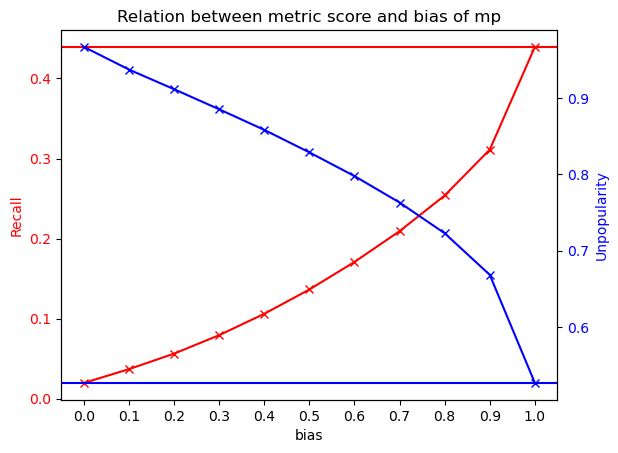

In [12]:
# グラフの描画
fig, ax1 = plt.subplots()

# Y軸1 (左側の軸) の設定
ax1.set_xlabel('bias')
ax1.set_ylabel('Recall', color='red')
ax1.plot(bias_li, re_recall, color='red', marker='x')
ax1.tick_params(axis='y', labelcolor='red')

# Y軸2 (右側の軸) の設定
ax2 = ax1.twinx()
ax2.set_ylabel('Unpopularity', color='blue')
ax2.plot(bias_li, re_unpop1, color='blue', marker='x')
ax2.tick_params(axis='y', labelcolor='blue')

# グラフのタイトルとX軸のメモリの設定
plt.title('Relation between metric score and bias of mp')
ax1.set_xticks(bias_li)
ax1.set_xticklabels(bias_li)

# 基準線の設定
# Base CML
ax1.axhline(re_base.iloc[-1, 7], color='red', linestyle='-')
ax2.axhline(re_base.iloc[-1, 8], color='blue', linestyle='-')
# No training
# ax1.axhline(re_no_training.iloc[-1, 7], color='red', linestyle='--')
# ax2.axhline(re_no_training.iloc[-1, 8], color='blue', linestyle='--')

# グラフの表示
plt.show()

## Recall vs Unpopularity2

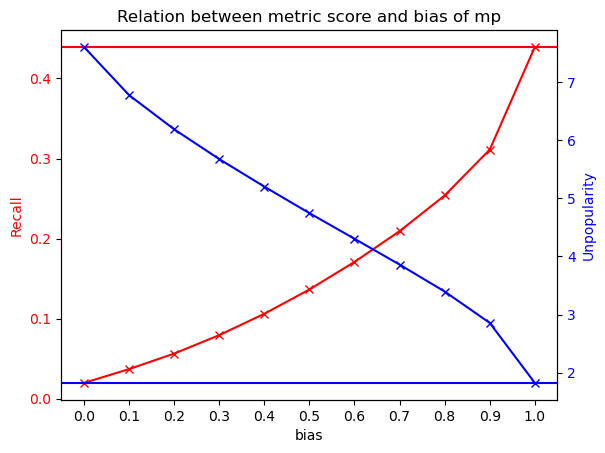

In [13]:
# グラフの描画
fig, ax1 = plt.subplots()

# Y軸1 (左側の軸) の設定
ax1.set_xlabel('bias')
ax1.set_ylabel('Recall', color='red')
ax1.plot(bias_li, re_recall, color='red', marker='x')
ax1.tick_params(axis='y', labelcolor='red')

# Y軸2 (右側の軸) の設定
ax2 = ax1.twinx()
ax2.set_ylabel('Unpopularity', color='blue')
ax2.plot(bias_li, re_unpop2, color='blue', marker='x')
ax2.tick_params(axis='y', labelcolor='blue')

# グラフのタイトルとX軸のメモリの設定
plt.title('Relation between metric score and bias of mp')
ax1.set_xticks(bias_li)
ax1.set_xticklabels(bias_li)

# 基準線の設定
# Base CML
ax1.axhline(re_base.iloc[-1, 7], color='red', linestyle='-')
ax2.axhline(re_base.iloc[-1, 9], color='blue', linestyle='-')
# No training
# ax1.axhline(re_no_training.iloc[-1, 7], color='red', linestyle='--')
# ax2.axhline(re_no_training.iloc[-1, 9], color='blue', linestyle='--')

# グラフの表示
plt.show()

## Recall vs Unpopularity3

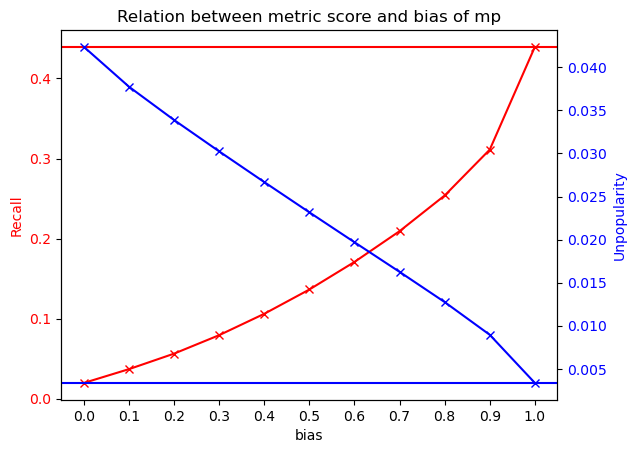

In [14]:
# グラフの描画
fig, ax1 = plt.subplots()

# Y軸1 (左側の軸) の設定
ax1.set_xlabel('bias')
ax1.set_ylabel('Recall', color='red')
ax1.plot(bias_li, re_recall, color='red', marker='x')
ax1.tick_params(axis='y', labelcolor='red')

# Y軸2 (右側の軸) の設定
ax2 = ax1.twinx()
ax2.set_ylabel('Unpopularity', color='blue')
ax2.plot(bias_li, re_unpop3, color='blue', marker='x')
ax2.tick_params(axis='y', labelcolor='blue')

# グラフのタイトルとX軸のメモリの設定
plt.title('Relation between metric score and bias of mp')
ax1.set_xticks(bias_li)
ax1.set_xticklabels(bias_li)

# 基準線の設定
# Base CML
ax1.axhline(re_base.iloc[-1, 7], color='red', linestyle='-')
ax2.axhline(re_base.iloc[-1, 10], color='blue', linestyle='-')
# No training
# ax1.axhline(re_no_training.iloc[-1, 7], color='red', linestyle='--')
# ax2.axhline(re_no_training.iloc[-1, 10], color='blue', linestyle='--')

# グラフの表示
plt.show()